In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
df = pd.read_csv('Preprocess_Reviews.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment,neg,neu,pos,compound
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,feel lucky found used phone u used hard phone ...,1.0,positive,0.100,0.592,0.308,0.8966
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,nice phone nice grade pantach revue clean set ...,0.0,positive,0.155,0.445,0.400,0.8548
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,5,pleased,0.0,positive,0.000,0.000,1.000,0.4404
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,work good go slow sometimes good phone love,0.0,positive,0.000,0.333,0.667,0.8750
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",samsung,199.99,4,great phone replace lost phone thing volume bu...,0.0,positive,0.103,0.714,0.183,0.4215


In [21]:
#Drop unnecessary columns:
df = df.drop(['Product Name', 'Price', 'Review Votes', 'Brand Name'], axis=1)
df.dropna(inplace=True)

In [22]:
df.head()

,Rating,Reviews,sentiment,neg,neu,pos,compound
0,5,feel lucky found used phone u used hard phone ...,positive,0.100,0.592,0.308,0.8966
1,4,nice phone nice grade pantach revue clean set ...,positive,0.155,0.445,0.400,0.8548
2,5,pleased,positive,0.000,0.000,1.000,0.4404
3,4,work good go slow sometimes good phone love,positive,0.000,0.333,0.667,0.8750
4,4,great phone replace lost phone thing volume bu...,positive,0.103,0.714,0.183,0.4215


<Axes: xlabel='Rating', ylabel='count'>

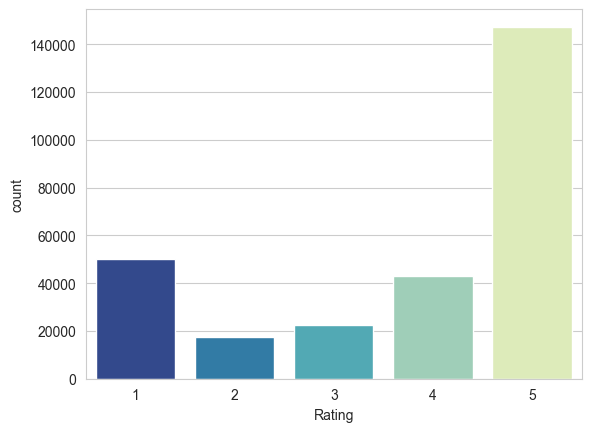

In [23]:
sns.set_style('whitegrid')
sns.countplot(x='Rating',data=df, palette='YlGnBu_r')

<Axes: xlabel='sentiment', ylabel='count'>

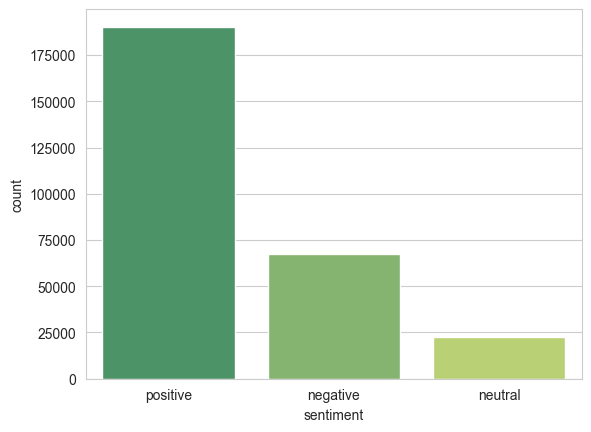

In [24]:
sns.set_style('whitegrid')
sns.countplot(x='sentiment',data=df, palette='summer')

In [25]:
print(df[df['sentiment'] == 'positive'].shape)
print(df[df['sentiment'] == 'negative'].shape)
print(df[df['sentiment'] == 'neutral'].shape)

(190339, 7)
(67557, 7)
(22605, 7)


# Data Pre-processing

In [26]:
df_Positive = df[df['sentiment'] == 'positive'][0:20000]
df_Neutral = df[df['sentiment'] == 'neutral']
df_Negative = df[df['sentiment'] == 'negative']

### Sample negative and neutral dataset and create a final dataset:

In [27]:
df_Neutral_over = df_Neutral.sample(20000, replace=True)
df_Negative_over = df_Negative.sample(20000, replace=True)
df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

In [28]:
df

,Rating,Reviews,sentiment,neg,neu,pos,compound
0,5,feel lucky found used phone u used hard phone ...,positive,0.100,0.592,0.308,0.8966
1,4,nice phone nice grade pantach revue clean set ...,positive,0.155,0.445,0.400,0.8548
2,5,pleased,positive,0.000,0.000,1.000,0.4404
3,4,work good go slow sometimes good phone love,positive,0.000,0.333,0.667,0.8750
4,4,great phone replace lost phone thing volume bu...,positive,0.103,0.714,0.183,0.4215
...,...,...,...,...,...,...,...
76942,1,move slow,negative,0.000,1.000,0.000,0.0000
35244,1,horrible,negative,1.000,0.000,0.000,-0.5423
265229,1,work daughteronly served charger connected,negative,0.000,1.000,0.000,0.0000
49539,1,phone ordered disappointed order,negative,0.508,0.492,0.000,-0.4767


In [29]:
df.shape

(60000, 7)

### Apply One hot encoding on negative, neural, and positive:

In [30]:
one_hot = pd.get_dummies(df["sentiment"])
df.drop(["sentiment"], axis=1, inplace=True)
df = pd.concat([df, one_hot], axis=1)
df.head()

,Rating,Reviews,neg,neu,pos,compound,negative,neutral,positive
0,5,feel lucky found used phone u used hard phone ...,0.100,0.592,0.308,0.8966,False,False,True
1,4,nice phone nice grade pantach revue clean set ...,0.155,0.445,0.400,0.8548,False,False,True
2,5,pleased,0.000,0.000,1.000,0.4404,False,False,True
3,4,work good go slow sometimes good phone love,0.000,0.333,0.667,0.8750,False,False,True
4,4,great phone replace lost phone thing volume bu...,0.103,0.714,0.183,0.4215,False,False,True


### Apply train test split:

In [31]:
X = df["Reviews"].values
y = df.drop("Reviews", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Apply vectorization:

In [32]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

### Apply frequency, inverse document frequency:

In [33]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [34]:
# Convert labels to float32
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Build a Model with Deep Learning

### Add different layers to models:

In [35]:
model = Sequential()
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)

### Fit the model:

In [36]:
model.fit(
x=X_train,
y=y_train,
batch_size=128,
epochs=10,
validation_data=(X_test, y_test),
verbose=1,
callbacks=early_stop
)


MemoryError: Unable to allocate 4.52 GiB for an array with shape (42000, 28861) and data type float32

# Evaluation of Model

In [25]:
model_score = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("Test accuracy:", model_score[1])

141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8692 - loss: 0.5235
Test accuracy: 0.8675000071525574


# Prediction of Result

In [27]:
preds = model.predict(X_test)
print(preds)

563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
[[6.87302789e-03 1.82578322e-02 9.74869192e-01]
 [1.02686845e-02 9.38792229e-01 5.09390756e-02]
 [1.33334030e-03 9.98444378e-01 2.22253468e-04]
 ...
 [8.42983127e-02 9.63326097e-02 8.19369137e-01]
 [8.48605707e-02 6.57228306e-02 8.49416614e-01]
 [6.14496283e-02 1.61135703e-01 7.77414739e-01]]
